In [1]:
!pip install rasterio
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.4 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 4.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 9.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.0 MB/s eta 0:00:00a 0:00:01


../cropped_NDBI/MODIS_ndbi_2010.tif: 5845
../cropped_MODIS_bands/MODIS_sur_refl_b01_2010.tif: 5845
../cropped_MODIS_bands/MODIS_sur_refl_b02_2010.tif: 5845
../cropped_MODIS_bands/MODIS_sur_refl_b03_2010.tif: 5845
../cropped_MODIS_bands/MODIS_sur_refl_b04_2010.tif: 5845
../cropped_MODIS_bands/MODIS_sur_refl_b05_2010.tif: 5845
../cropped_MODIS_bands/MODIS_sur_refl_b06_2010.tif: 5845
../cropped_MODIS_bands/MODIS_sur_refl_b07_2010.tif: 5845


Plotting TIF Files:   0%|          | 0/8 [00:00<?, ?it/s]

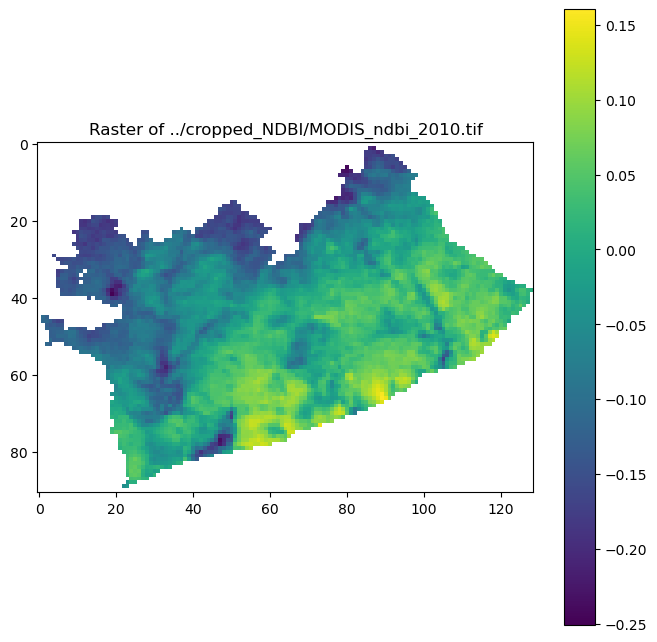

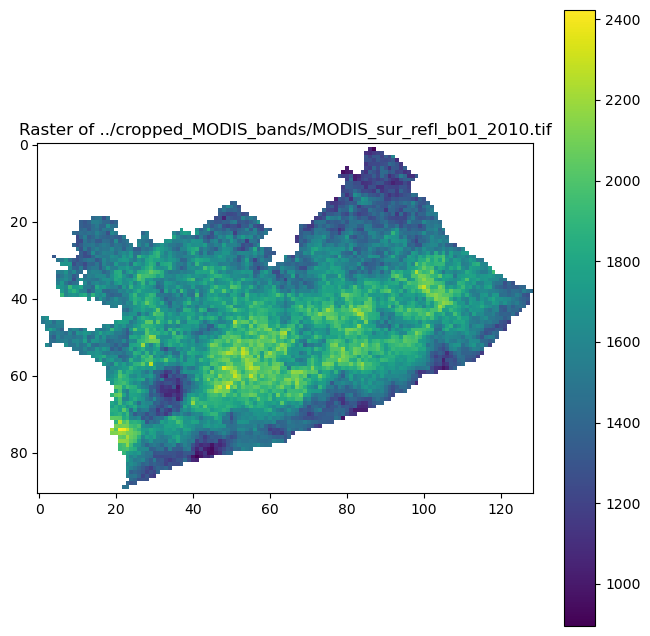

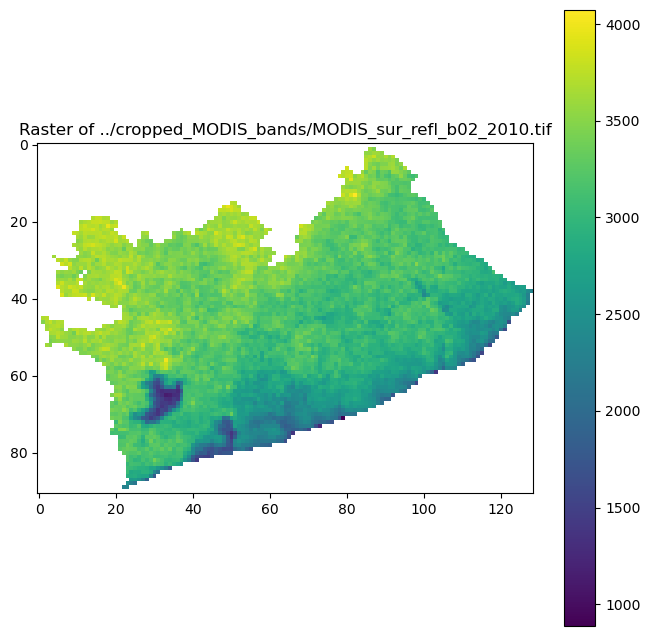

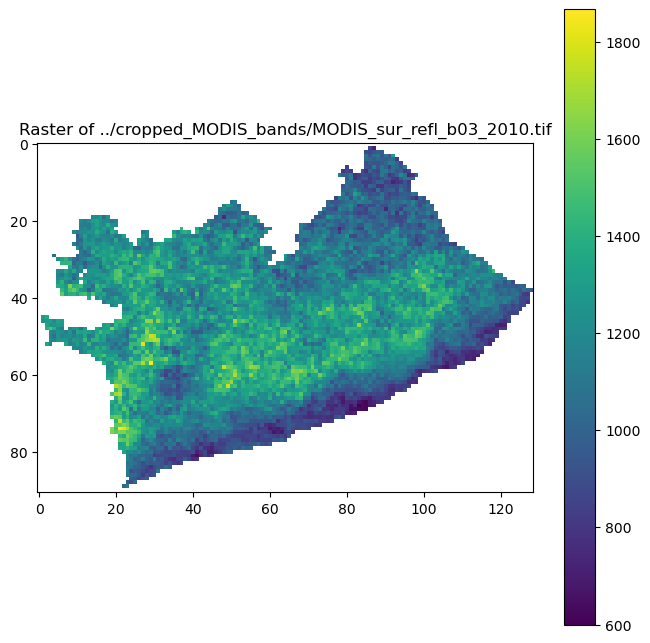

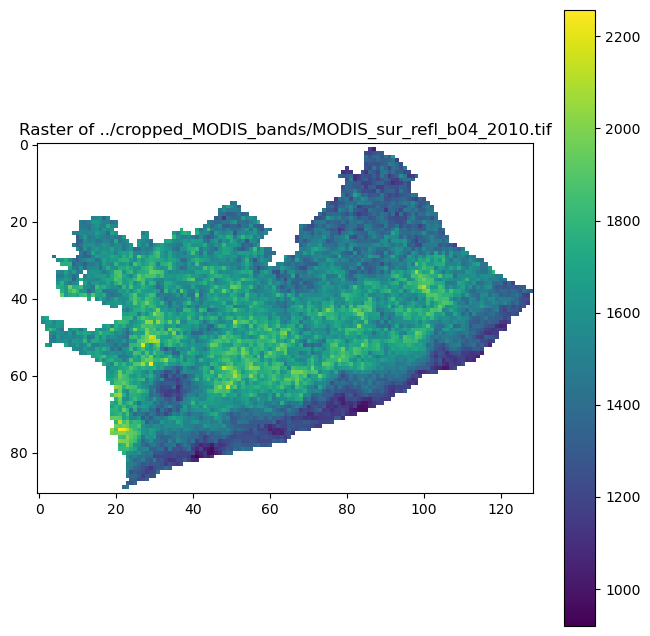

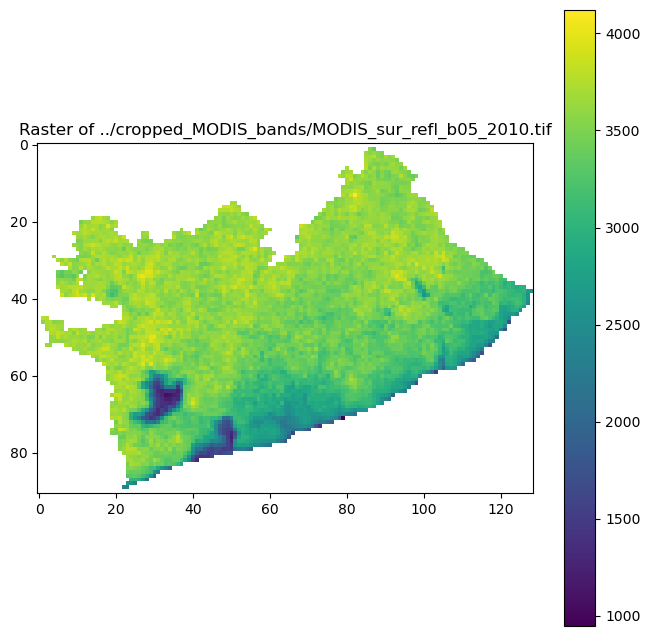

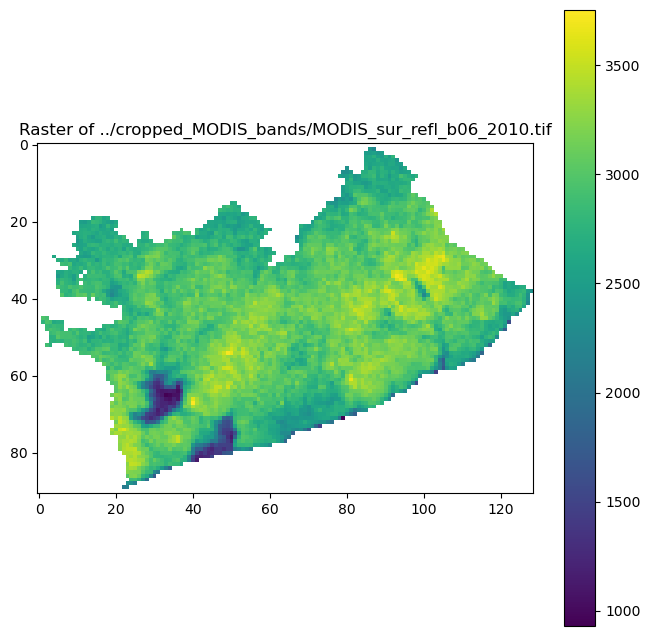

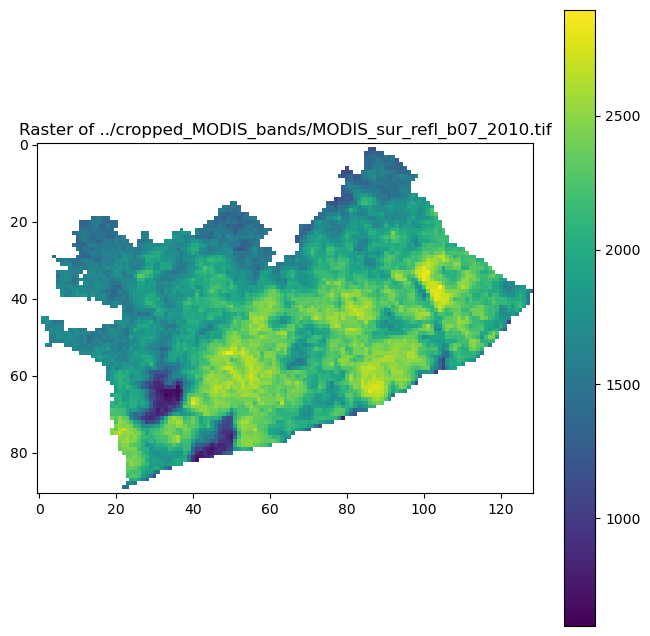

In [2]:
from tqdm.notebook import tqdm
import rasterio
from rasterio.features import shapes
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, shape
import os
from rasterio.transform import rowcol
from rasterio.transform import xy

# Load the building points shapefile
building_points = gpd.read_file('../building_points/land_classifications_2010.shp')

# NDBI TIFF
ndbi_tiff = '../cropped_NDBI/MODIS_ndbi_2010.tif'

# MODIS bands directory and file paths
modis_dir = '../cropped_MODIS_bands'
band_files = [f"{modis_dir}/MODIS_sur_refl_b0{i}_2010.tif" for i in range(1, 8)]

# List of TIF files including NDBI and MODIS bands
tiff_files = [ndbi_tiff] + band_files

# Initialize a dictionary to hold the count of valid pixels for each file
valid_pixels_count = {}

for tiff_file in tiff_files:
    with rasterio.open(tiff_file) as src:
        data = src.read(1)  # Read the first band
        # Count the non-NaN values
        non_nan_count = np.count_nonzero(~np.isnan(data))
        valid_pixels_count[tiff_file] = non_nan_count

# Display the count of valid pixels for each file
for file, count in valid_pixels_count.items():
    print(f"{file}: {count}")

# Plot each TIF file
for tiff_file in tqdm(tiff_files, desc='Plotting TIF Files'):
    with rasterio.open(tiff_file) as src:
        data = src.read(1)  # Read the first band
        
        # Plot the data
        plt.figure(figsize=(8, 8))
        plt.title(f"Raster of {tiff_file}")
        plt.imshow(data, cmap='viridis')
        plt.colorbar()
        plt.savefig('../debug_plots/'+tiff_file.split(os.sep)[-1].split('/')[0]+'_2010.png')


In [42]:
building_points['land_categ'].value_counts()

land_categ
building               672135
incomplete_building     42762
Name: count, dtype: int64

In [3]:
# Initialize an array to hold all band data and a list for pixel geometries
all_bands_data = []
pixel_polygons = []

# Read and process each band
for i, band_file in enumerate(tqdm(band_files, desc='Reading MODIS Bands')):
    with rasterio.open(band_file) as src:
        # Read the band data and mask
        band_data = src.read(1, masked=True)
        # Ensure data is of dtype float32, as required by shapes function
        band_data_float32 = band_data.astype('float32')
        all_bands_data.append(band_data_float32)

        # For the first band, get the pixel geometries
        if i == 0:
            # Mask is a boolean array with True for valid pixels
            mask = np.logical_not(band_data.mask)
            for geom, value in shapes(band_data_float32, mask=mask, transform=src.transform):
                pixel_polygons.append(box(*shape(geom).bounds))

# Read the NDBI band
with rasterio.open(ndbi_tiff) as src:
    ndbi_data = src.read(1, masked=True)

print(len(ndbi_data))

# Combine all band data including NDBI
all_bands_data.insert(0, ndbi_data)  # Assuming you want NDBI as the first band
all_bands_combined = np.ma.stack(all_bands_data)

# Create a GeoDataFrame with pixel geometries
pixel_df = gpd.GeoDataFrame({'geometry': pixel_polygons}, crs=src.crs)

# Flatten the combined bands data, exclude masked (invalid) pixels
valid_pixels_mask = np.logical_not(all_bands_combined.mask.any(axis=0))

# Find the row and column indices for all valid pixels
valid_row_indices, valid_col_indices = np.where(valid_pixels_mask)

# Create the geometries for the valid pixels
transform = src.transform  # assuming the transform is the same for all bands
pixel_polygons = [
    box(
        *xy(transform, row, col, offset='ul'), 
        *xy(transform, row + 1, col + 1, offset='ul')
    ) for row, col in zip(valid_row_indices, valid_col_indices)
]

# Flatten the data arrays, only keeping the valid pixels
flat_pixels_data = all_bands_combined[:, valid_pixels_mask].data.T

# Now we create the GeoDataFrame and assign values to it
pixel_df = gpd.GeoDataFrame({'geometry': pixel_polygons}, crs=src.crs)
for i, band_name in enumerate(['NDBI'] + [f"MODIS_band_{i}" for i in range(1, 8)]):
    pixel_df[band_name] = flat_pixels_data[:, i]
    
# Spatial join to count buildings and get coverage within each pixel
pixel_df = pixel_df.set_crs(building_points.crs, allow_override=True)
pixel_buildings = gpd.sjoin(pixel_df, building_points, how='left', predicate='contains')
pixel_buildings_count = pixel_buildings.groupby(pixel_buildings.index).size()
pixel_building_coverage = pixel_buildings.groupby(pixel_buildings.index)['area_m2'].sum()

# Merge the spatial join results back into pixel_df
pixel_df['building_count'] = pixel_buildings_count.reindex(pixel_df.index, fill_value=0)
pixel_df['building_coverage'] = pixel_building_coverage.reindex(pixel_df.index, fill_value=0)

# Inverse power transformation
pixel_df['sqrt_building_count'] = np.sqrt(pixel_df['building_count'])
pixel_df['sqrt_building_coverage'] = np.sqrt(pixel_df['building_coverage'])

Reading MODIS Bands:   0%|          | 0/7 [00:00<?, ?it/s]

91


In [ ]:
# fig, ax = plt.subplots()

# pixel_df.building_count.hist(ax=ax)

# plt.savefig('building_counts.png')

# fig, ax = plt.subplots()

# pixel_df.building_coverage.hist(ax=ax)

# plt.savefig('building_coverage.png')

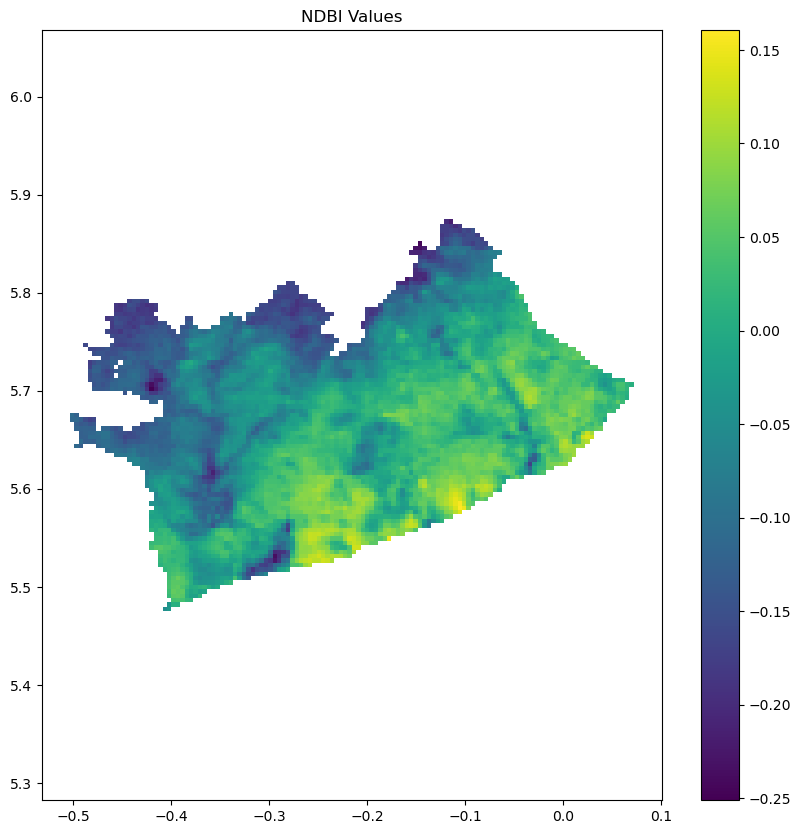

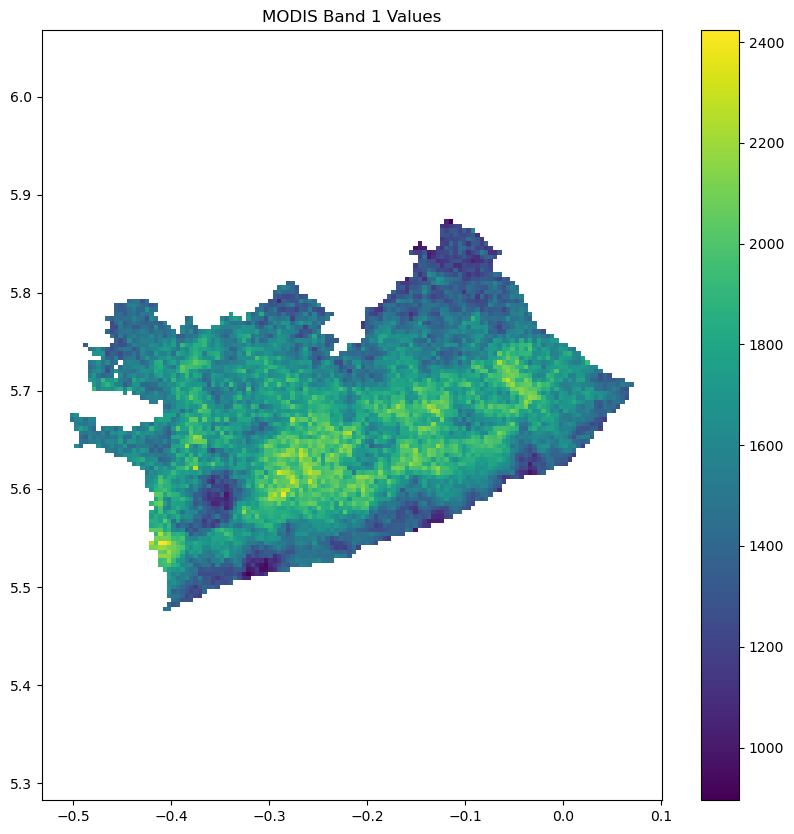

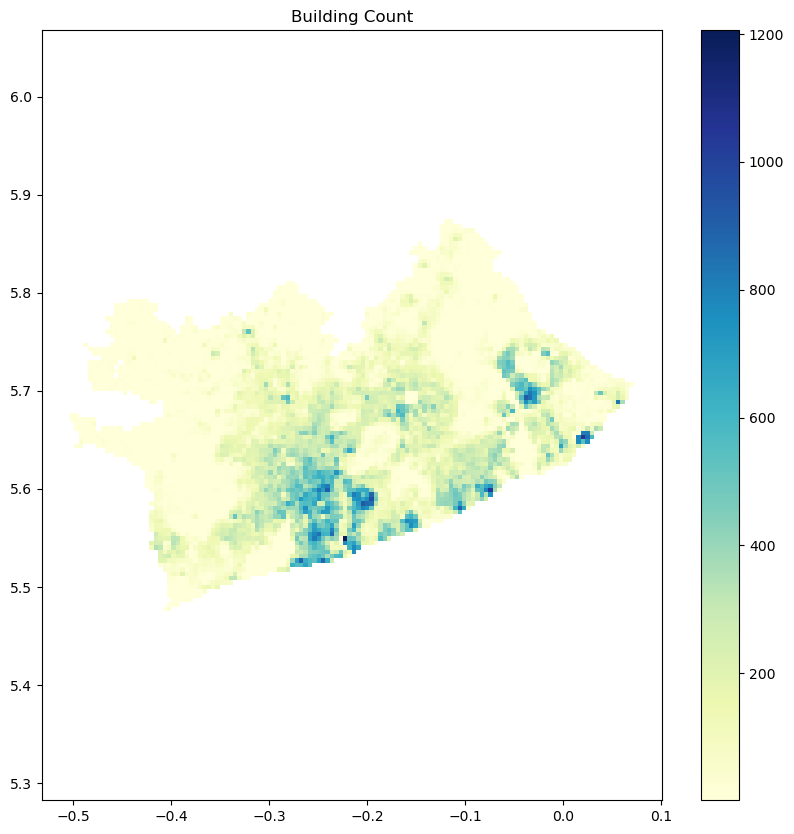

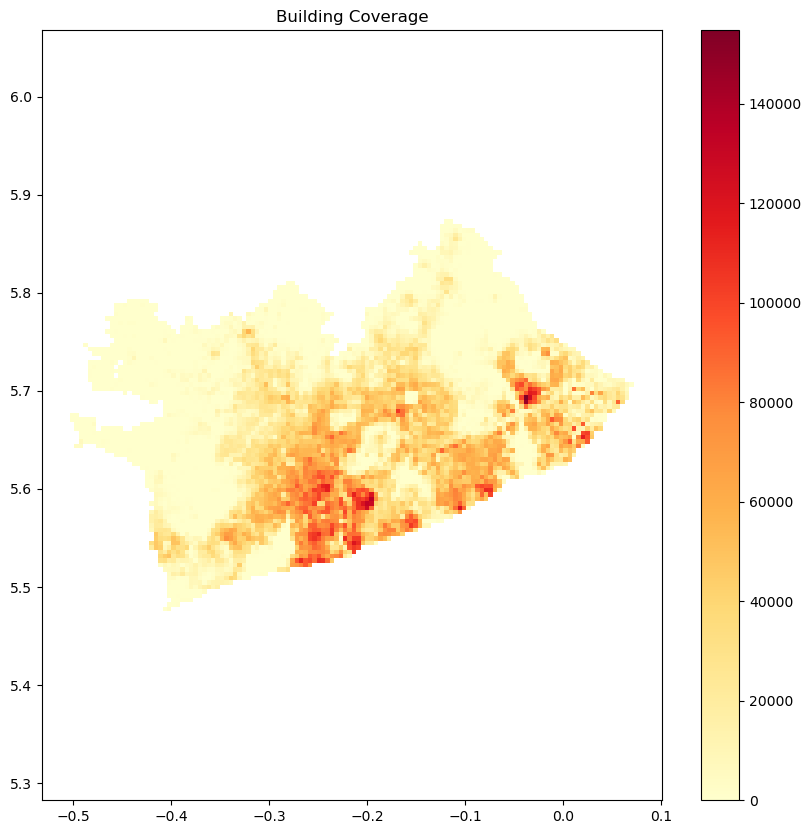

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Assuming pixel_df is your GeoDataFrame with the correct CRS (Coordinate Reference System)
# and it contains columns like 'NDBI', 'MODIS_band_X', 'building_count', 'building_coverage'

def plot_column(gdf, column_name, title, cmap='viridis'):
    """
    Plot a specific column of the GeoDataFrame.
    
    Parameters:
    - gdf: GeoDataFrame to plot.
    - column_name: The name of the column to plot.
    - title: The title of the plot.
    - cmap: The colormap to use.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(column=column_name, ax=ax, legend=True, cmap=cmap)
    plt.title(title)
    plt.axis('equal')
    plt.savefig('../debug_plots/'+title+'_2010.png')

# Example: Plotting NDBI values
plot_column(pixel_df, 'NDBI', 'NDBI Values')

# You can similarly plot other columns by changing the 'column_name' parameter:
# Plotting MODIS band 1 values
plot_column(pixel_df, 'MODIS_band_1', 'MODIS Band 1 Values')

# Plotting building count
plot_column(pixel_df, 'building_count', 'Building Count', cmap='YlGnBu')

# Plotting building coverage
plot_column(pixel_df, 'building_coverage', 'Building Coverage', cmap='YlOrRd')


Count Prediction:
Average RMSE: 83.96394010957933
Average R2: 0.7325682187625299
Average MAPE: 394.3032702844161

Coverage Prediction:
Average RMSE: 11351.096122883848
Average R2: 0.8130091612104478
Average MAPE: 355.90044568743366



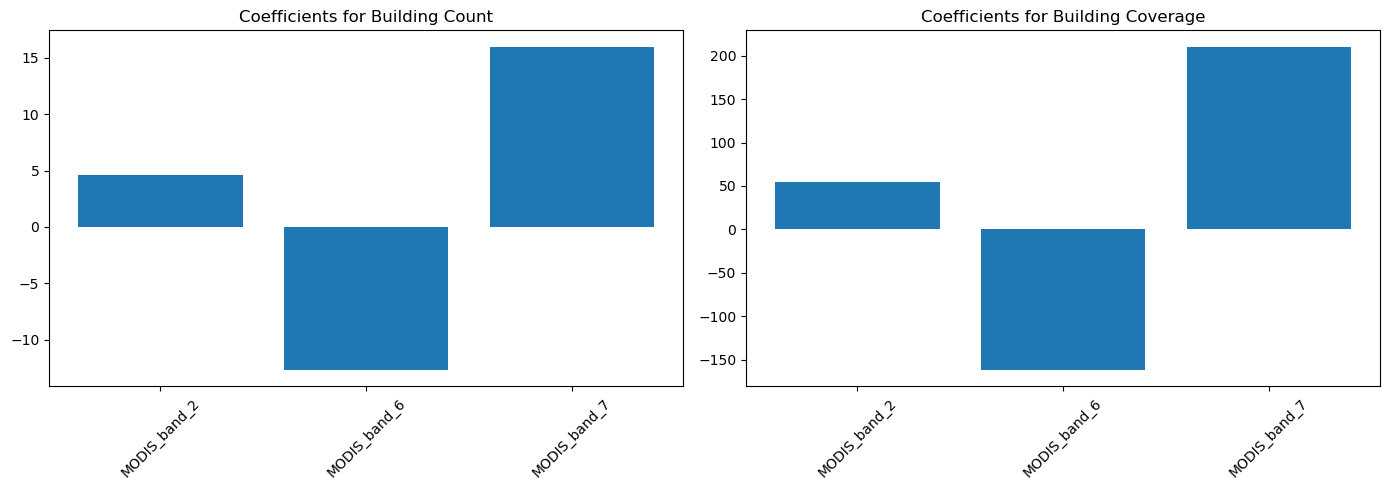

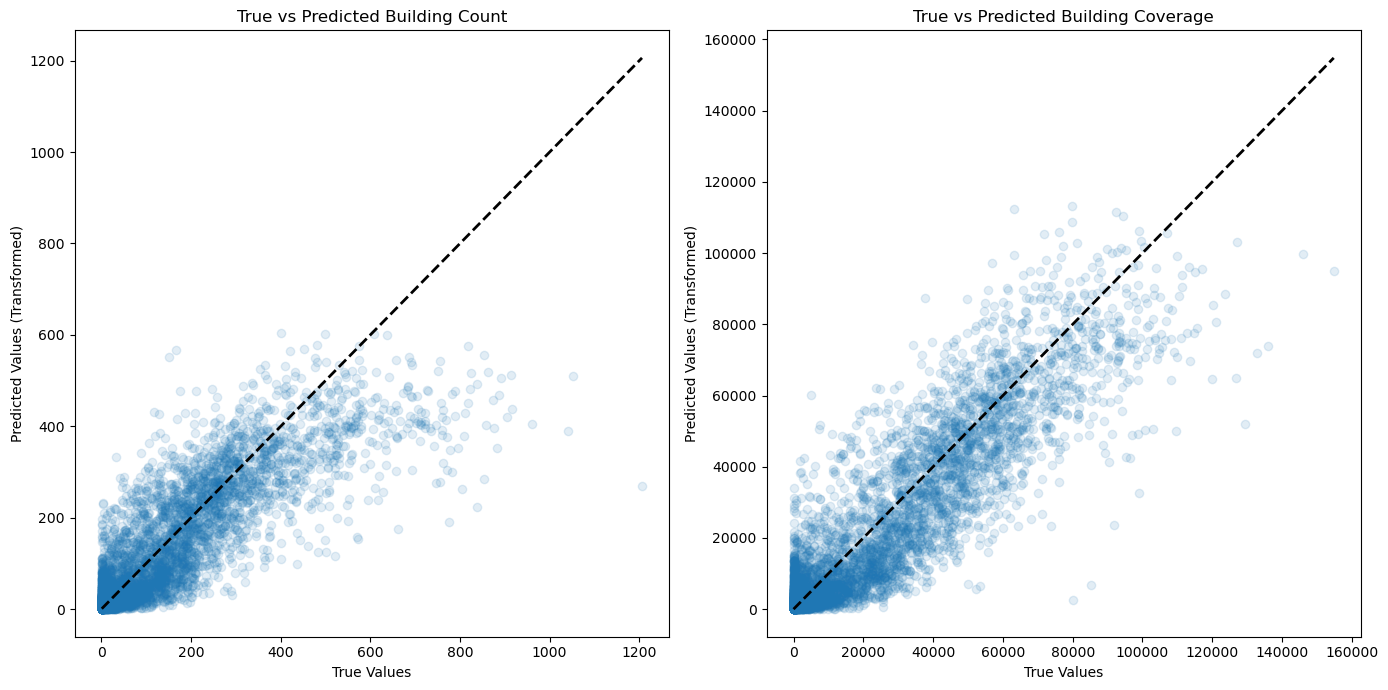

In [44]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to select model type
def get_model(model_type='lasso'):
    if model_type == 'lasso':
        return LassoCV(cv=5, max_iter=10000)
    elif model_type == 'linear':
        return LinearRegression()
    else:
        raise ValueError("Invalid model type. Choose 'lasso' or 'linear'.")

# Function to apply the inverse transformation for plotting
def inverse_transform(y, transformation=None):
    if transformation == 'sqrt':
        return np.square(y)
    else:
        return y

# Decide which transformation to use: 'sqrt' or None for linear
transformation = 'sqrt'  # Change to None for linear data

# Decide which bands to use
band_array = [2, 6, 7]  # Use None for all bands
# band_array = [1, 2, 3, 4, 5, 6, 7]  # Use None for all bands
model_type = 'lasso'

# Prepare the data based on selected bands
if band_array is None:
    features = [f'MODIS_band_{i}' for i in range(1, 8)]
else:
    features = [f'MODIS_band_{i}' for i in band_array]

X = pixel_df[features].values

# Update targets to transformed columns if required
y_count = pixel_df['sqrt_building_count'].values
y_coverage = pixel_df['sqrt_building_coverage'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a 6-fold split strategy
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Initialize lists to store metrics for each target
metrics = {
    "count": {"rmse": [], "r2": [], "mape": []},
    "coverage": {"rmse": [], "r2": [], "mape": []}
}

# Function to calculate MAPE, avoiding division by zero
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

# Cross-validation loop
for train_index, test_index in kf.split(X_scaled):
    for target, y in [("count", y_count), ("coverage", y_coverage)]:
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = get_model(model_type=model_type).fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_test_reverse_transformed = inverse_transform(y_test, transformation)
        y_pred_reverse_transformed = inverse_transform(y_pred, transformation)
        
        metrics[target]["rmse"].append(mean_squared_error(y_test_reverse_transformed, y_pred_reverse_transformed, squared=False))
        metrics[target]["r2"].append(r2_score(y_test_reverse_transformed, y_pred_reverse_transformed))
        metrics[target]["mape"].append(calculate_mape(y_test_reverse_transformed, y_pred_reverse_transformed))

# Print average MSE, R^2, and MAPE for both targets
for target in metrics:
    print(f"{target.capitalize()} Prediction:")
    for metric in metrics[target]:
        print(f"Average {metric.upper()}: {np.mean(metrics[target][metric])}")
    print()

# Plotting coefficients for the models trained on the entire dataset
plt.figure(figsize=(14, 5))

for i, (target, y) in enumerate([("count", y_count), ("coverage", y_coverage)]):
    model = get_model(model_type=model_type).fit(X_scaled, y)
    plt.subplot(1, 2, i+1)
    plt.bar(range(len(features)), model.coef_)
    plt.title(f'Coefficients for Building {target.capitalize()}')
    plt.xticks(range(len(features)), features, rotation=45)

plt.tight_layout()
plt.show()

# Arrays to store final predictions and true values for visualization
final_y_true_count = []
final_y_pred_count = []
final_y_true_coverage = []
final_y_pred_coverage = []

# Cross-validation for prediction and plotting
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train_count, y_test_count = y_count[train_index], y_count[test_index]
    y_train_coverage, y_test_coverage = y_coverage[train_index], y_coverage[test_index]
    
    model_count = get_model(model_type=model_type).fit(X_train, y_train_count)
    model_coverage = get_model(model_type=model_type).fit(X_train, y_train_coverage)
    
    y_pred_count = model_count.predict(X_test)
    y_pred_coverage = model_coverage.predict(X_test)
    
    # Store predictions and true values
    final_y_true_count.extend(y_test_count)
    final_y_pred_count.extend(y_pred_count)
    final_y_true_coverage.extend(y_test_coverage)
    final_y_pred_coverage.extend(y_pred_coverage)

# Apply inverse transformation if needed
final_y_true_count, final_y_pred_count = inverse_transform(final_y_true_count, transformation), inverse_transform(final_y_pred_count, transformation)
final_y_true_coverage, final_y_pred_coverage = inverse_transform(final_y_true_coverage, transformation), inverse_transform(final_y_pred_coverage, transformation)

# Plotting predictions against true values for Building Count
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(final_y_true_count, final_y_pred_count, alpha=0.125)
plt.plot([min(final_y_true_count), max(final_y_true_count)], [min(final_y_true_count), max(final_y_true_count)], 'k--', lw=2)
plt.title('True vs Predicted Building Count')
plt.xlabel('True Values')
plt.ylabel('Predicted Values' + (' (Transformed)' if transformation else ''))

plt.subplot(1, 2, 2)
plt.scatter(final_y_true_coverage, final_y_pred_coverage, alpha=0.125)
plt.plot([min(final_y_true_coverage), max(final_y_true_coverage)], [min(final_y_true_coverage), max(final_y_true_coverage)], 'k--', lw=2)
plt.title('True vs Predicted Building Coverage')
plt.xlabel('True Values')
plt.ylabel('Predicted Values' + (' (Transformed)' if transformation else ''))

plt.tight_layout()
plt.savefig('../debug_plots/model_performance_2010.png')
plt.show()

Final Model Coefficients:
Building Count Model Coefficients:
{'MODIS_band_2': 4.627329, 'MODIS_band_6': -12.711601, 'MODIS_band_7': 15.996194}

Building Coverage Model Coefficients:
{'MODIS_band_2': 54.986973, 'MODIS_band_6': -162.01718, 'MODIS_band_7': 210.44247}


Final Model Evaluation Metrics:
Building Count:
RMSE: 83.99695561289174
R^2: 0.7327715805070439
MAPE: 393.3456895670661

Building Coverage:
RMSE: 11353.413974743416
R^2: 0.8133255246379811
MAPE: 354.7050335967174


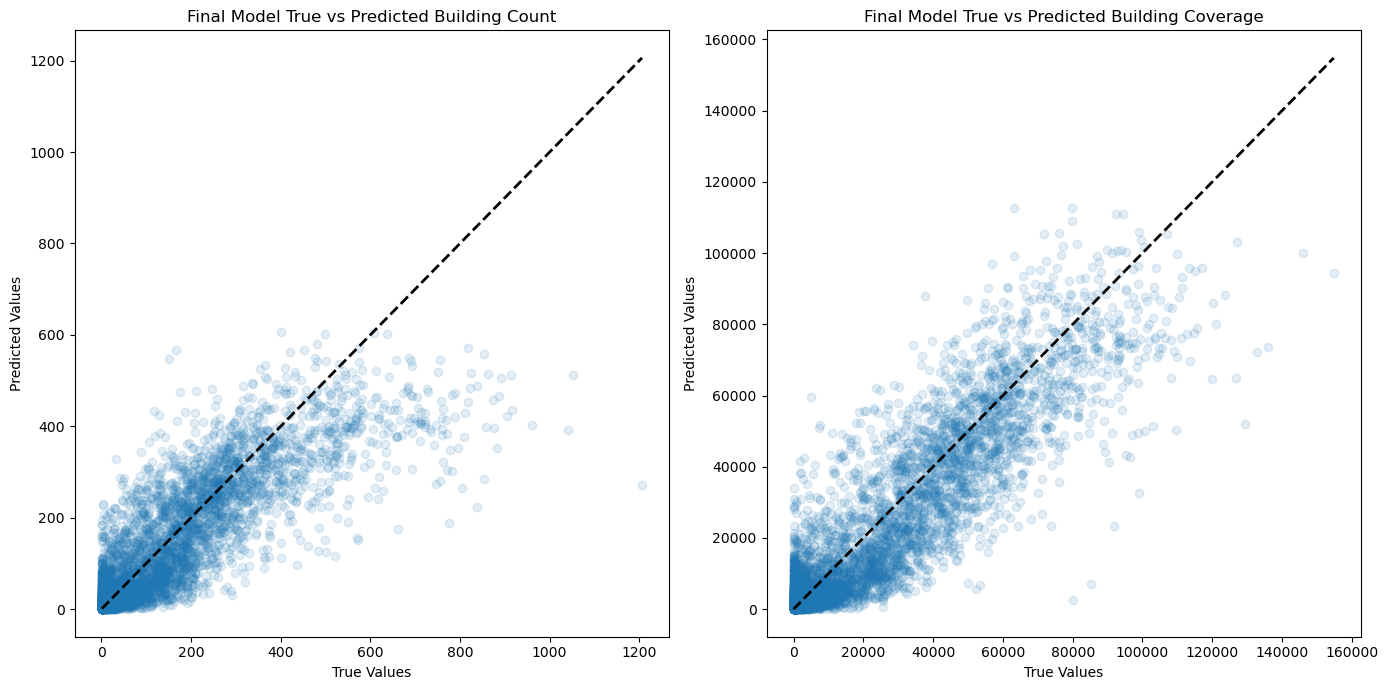

In [38]:
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# Decide which bands to use - to dynamically select bands based on band_array
band_array = [2, 6, 7]  # Specify the band numbers you want to include, or None for all bands
features = [f'MODIS_band_{i}' for i in range(1, 8)] if band_array is None else [f'MODIS_band_{i}' for i in band_array]

X = pixel_df[features].values
y_count = pixel_df['sqrt_building_count'].values
y_coverage = pixel_df['sqrt_building_coverage'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize final models for count and coverage
final_model_count = get_model(model_type=model_type)
final_model_coverage = get_model(model_type=model_type)

# Train the final models on the entire dataset
final_model_count.fit(X_scaled, y_count)
final_model_coverage.fit(X_scaled, y_coverage)

# Print coefficients for both models
print("Final Model Coefficients:")
print("Building Count Model Coefficients:")
print(dict(zip(features, final_model_count.coef_)))
print("\nBuilding Coverage Model Coefficients:")
print(dict(zip(features, final_model_coverage.coef_)))

# Make predictions with the final models
y_pred_count_all = final_model_count.predict(X_scaled)
y_pred_coverage_all = final_model_coverage.predict(X_scaled)

# Function to apply inverse transformation for visualization
def inverse_transform(y, transformation='sqrt'):
    return np.square(y) if transformation == 'sqrt' else y

# Inverse transform the predictions (and true values if necessary)
y_pred_count_all = inverse_transform(y_pred_count_all, transformation='sqrt')
y_pred_coverage_all = inverse_transform(y_pred_coverage_all, transformation='sqrt')
y_count_true = inverse_transform(y_count, transformation='sqrt')
y_coverage_true = inverse_transform(y_coverage, transformation='sqrt')

# Add the final predictions to pixel_df
pixel_df['predicted_count'] = y_pred_count_all
pixel_df['predicted_coverage'] = y_pred_coverage_all

# Evaluation metrics for the final model, using the inversely transformed values
print("\n\nFinal Model Evaluation Metrics:")
print("Building Count:")
print(f"RMSE: {mean_squared_error(y_count_true, y_pred_count_all, squared=False)}")
print(f"R^2: {r2_score(y_count_true, y_pred_count_all)}")
print(f"MAPE: {calculate_mape(y_count_true, y_pred_count_all)}\n")

print("Building Coverage:")
print(f"RMSE: {mean_squared_error(y_coverage_true, y_pred_coverage_all, squared=False)}")
print(f"R^2: {r2_score(y_coverage_true, y_pred_coverage_all)}")
print(f"MAPE: {calculate_mape(y_coverage_true, y_pred_coverage_all)}")

# Plotting the final model predictions against true values
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_count_true, y_pred_count_all, alpha=0.125)
plt.plot([min(y_count_true), max(y_count_true)], [min(y_count_true), max(y_count_true)], 'k--', lw=2)
plt.title('Final Model True vs Predicted Building Count')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_coverage_true, y_pred_coverage_all, alpha=0.125)
plt.plot([min(y_coverage_true), max(y_coverage_true)], [min(y_coverage_true), max(y_coverage_true)], 'k--', lw=2)
plt.title('Final Model True vs Predicted Building Coverage')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()


In [40]:
import numpy as np

# Assuming y_ndbi, y_count_true, and y_coverage_true are already defined
correlation_count = np.corrcoef(y_ndbi, y_count_true)[0, 1]
correlation_coverage = np.corrcoef(y_ndbi, y_coverage_true)[0, 1]

print(f"Correlation between NDBI and Building Count: {correlation_count}")
print(f"Correlation between NDBI and Building Coverage: {correlation_coverage}")
print("\n")

# Assuming y_ndbi, y_count_true, and y_coverage_true are already defined
correlation_count = np.corrcoef(y_pred_count_all, y_count_true)[0, 1]
correlation_coverage = np.corrcoef(y_pred_coverage_all, y_coverage_true)[0, 1]

print(f"Correlation between Predicted and True Building Count: {correlation_count}")
print(f"Correlation between Predicted and True Building Coverage: {correlation_coverage}")
print("\n")

Correlation between NDBI and Building Count: 0.6508837391138156
Correlation between NDBI and Building Coverage: 0.7090916494530431


Correlation between Predicted and True Building Count: 0.8611358576140192
Correlation between Predicted and True Building Coverage: 0.9046480838403584




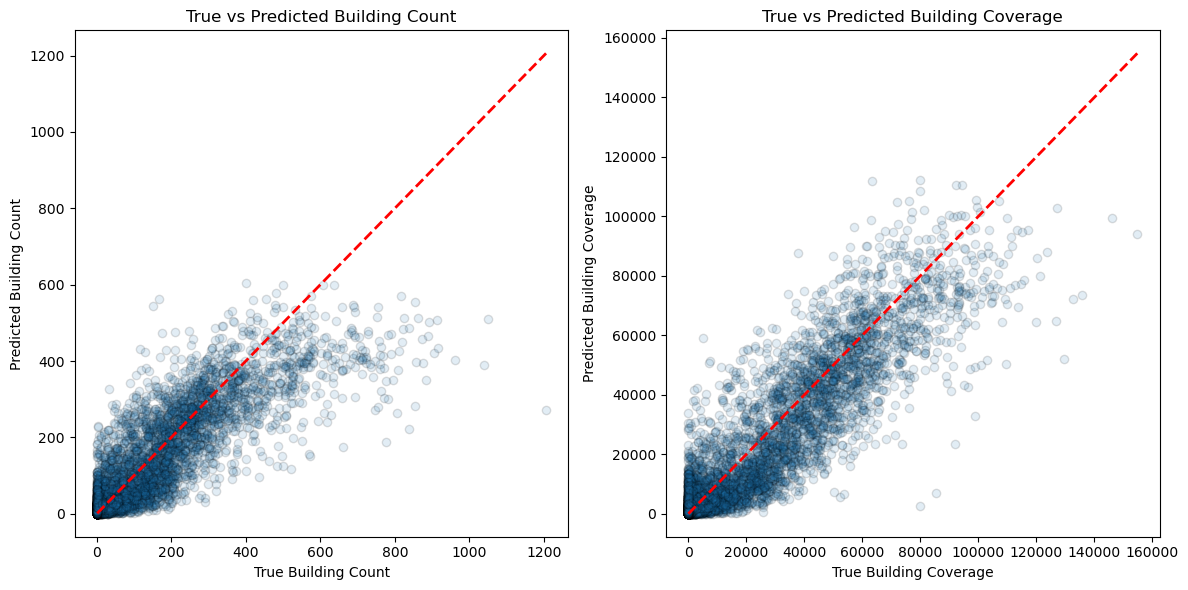

In [37]:
import matplotlib.pyplot as plt

# Assume y_pred_count_all and y_pred_coverage_all are obtained from the final models
# for the entire dataset.

# Plotting true vs predicted values for building counts
plt.figure(figsize=(12, 6))

# Subplot for building counts
plt.subplot(1, 2, 1)
plt.scatter(y_true_count, y_pred_count_all, alpha=0.125, edgecolor='k')
plt.title('True vs Predicted Building Count')
plt.xlabel('True Building Count')
plt.ylabel('Predicted Building Count')
plt.plot([min(y_true_count), max(y_true_count)], [min(y_true_count), max(y_true_count)], 'r--', lw=2)  # Red dashed line for reference

# Subplot for building coverage
plt.subplot(1, 2, 2)
plt.scatter(y_true_coverage, y_pred_coverage_all, alpha=0.125, edgecolor='k')
plt.title('True vs Predicted Building Coverage')
plt.xlabel('True Building Coverage')
plt.ylabel('Predicted Building Coverage')
plt.plot([min(y_true_coverage), max(y_true_coverage)], [min(y_true_coverage), max(y_true_coverage)], 'r--', lw=2)  # Red dashed line for reference

# Display the plot
plt.tight_layout()
plt.show()


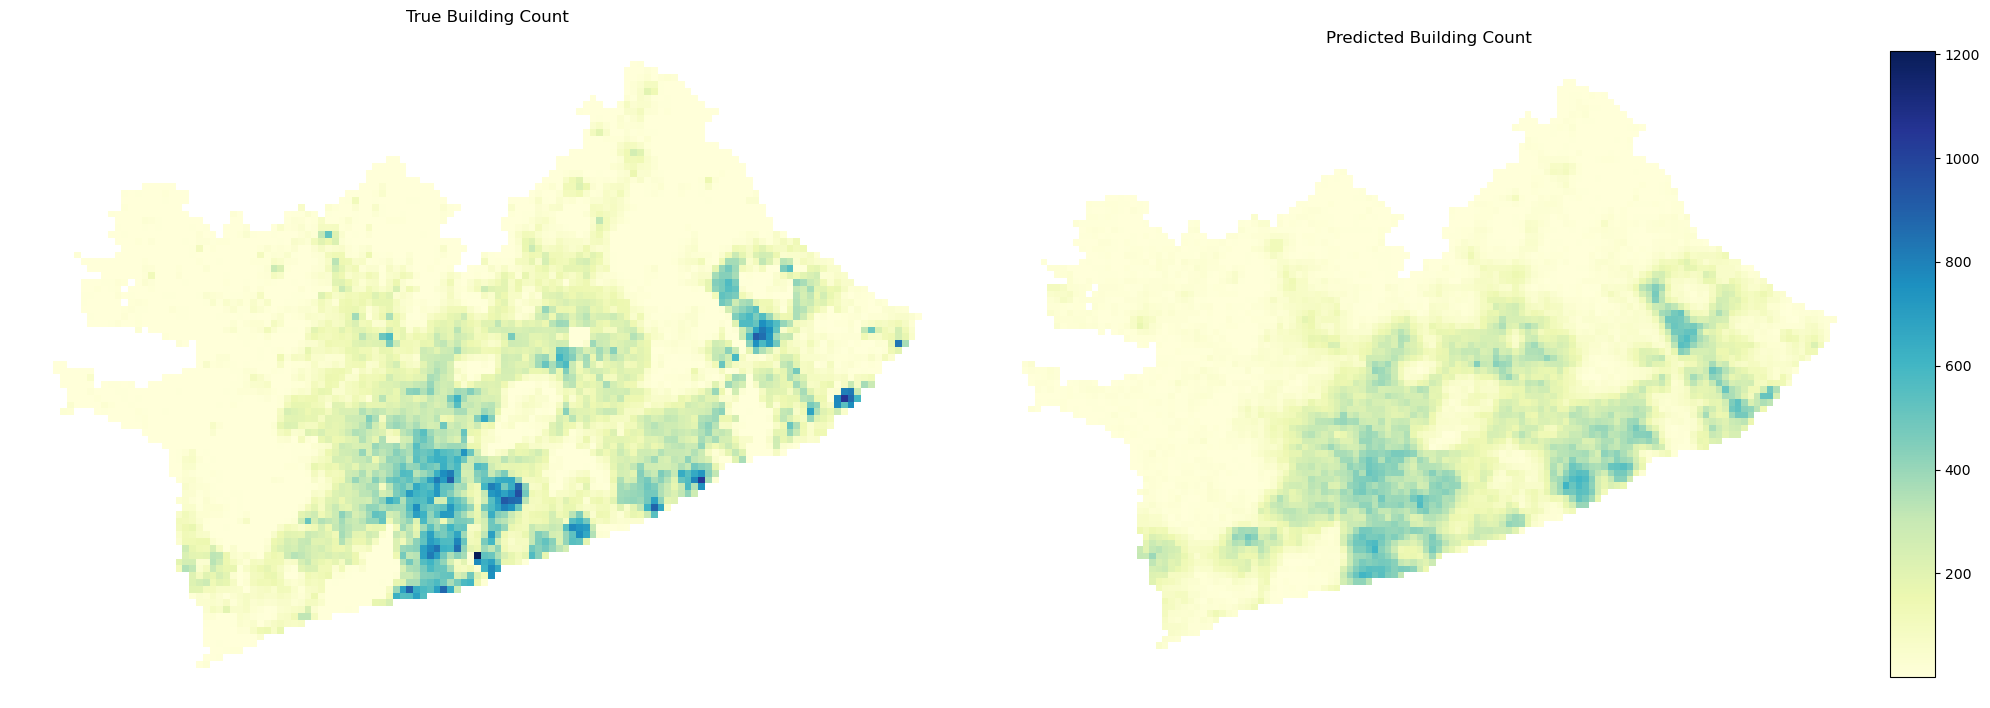

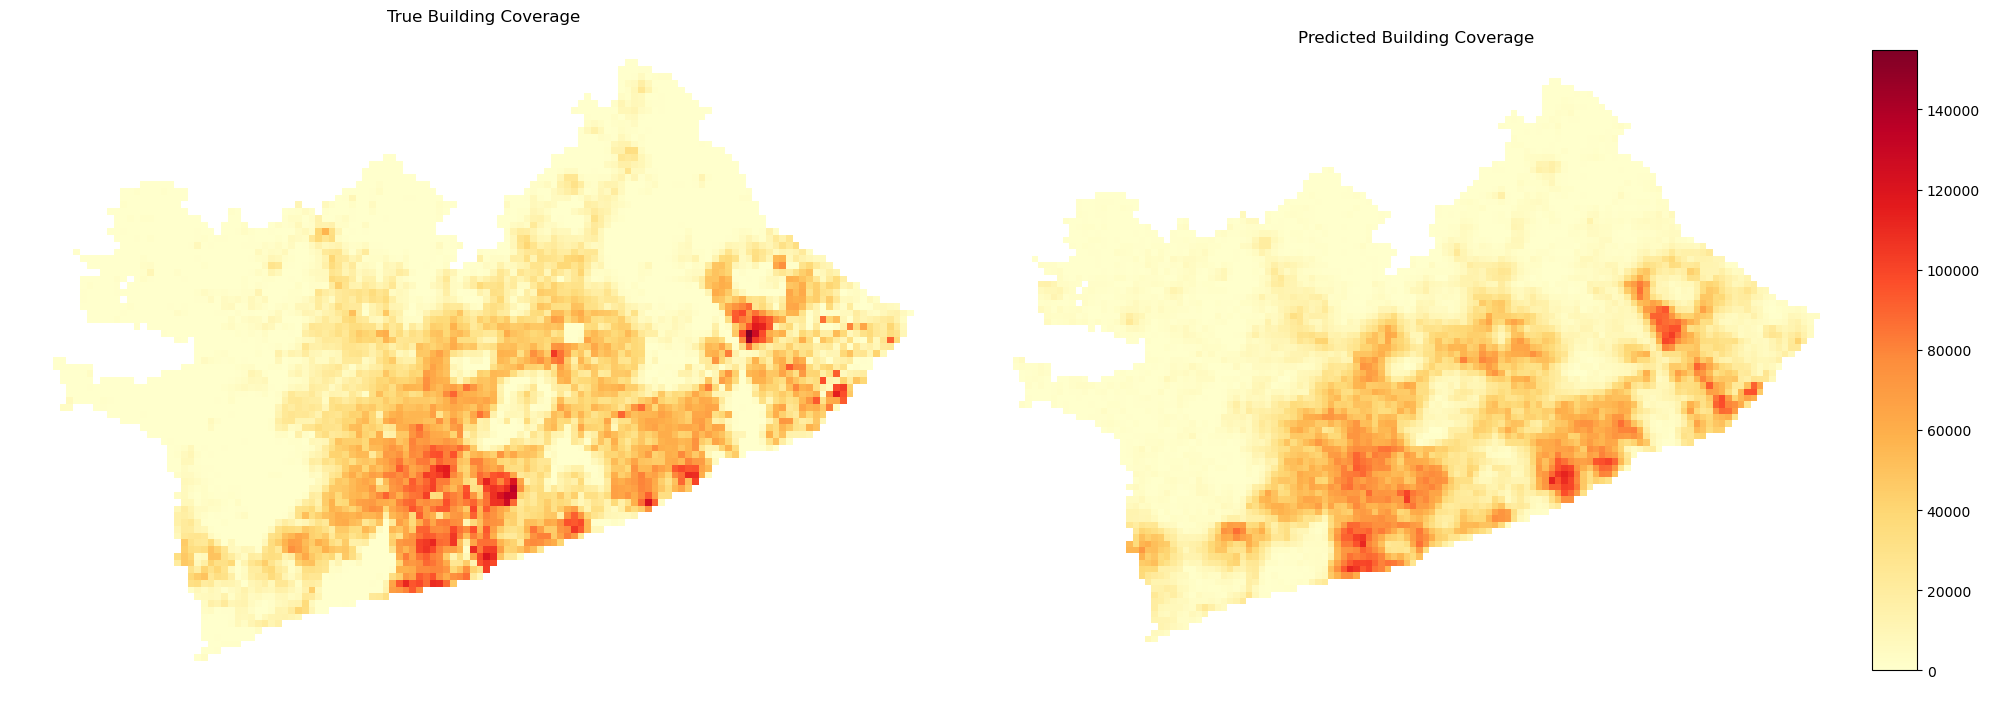

In [22]:
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming 'pixel_df' is your GeoDataFrame with the correct CRS
# Add the predicted values as new columns
pixel_df['predicted_count'] = y_pred_count_all
pixel_df['predicted_coverage'] = y_pred_coverage_all

def plot_true_vs_predicted(gdf, true_column, pred_column, true_title, pred_title, cmap='viridis'):
    """
    Plot the true and predicted values of a specific column of the GeoDataFrame side by side,
    with a common color scale and a shared colorbar.
    
    Parameters:
    - gdf: GeoDataFrame to plot.
    - true_column: The name of the column with true values.
    - pred_column: The name of the column with predicted values.
    - true_title: The title of the plot for true values.
    - pred_title: The title of the plot for predicted values.
    - cmap: The colormap to use.
    """
    # Find common range for colorbar
    vmin = min(gdf[true_column].min(), gdf[pred_column].min())
    vmax = max(gdf[true_column].max(), gdf[pred_column].max())

    fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
    
    # Plot for true values
    true_plot = gdf.plot(column=true_column, ax=axes[0], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title(true_title)
    axes[0].axis('off')

    # Plot for predicted values
    pred_plot = gdf.plot(column=pred_column, ax=axes[1], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title(pred_title)
    axes[1].axis('off')

    # Set the colorbar on the right side of the plots
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(pred_plot.get_children()[0], cax=cax, ax=[axes[0], axes[1]])
    
    # Tighten up layout
    plt.tight_layout()
    plt.show()

plot_true_vs_predicted(pixel_df, 'building_count', 'predicted_count',
'True Building Count', 'Predicted Building Count', cmap='YlGnBu')

plot_true_vs_predicted(pixel_df, 'building_coverage', 'predicted_coverage',
'True Building Coverage', 'Predicted Building Coverage', cmap='YlOrRd')

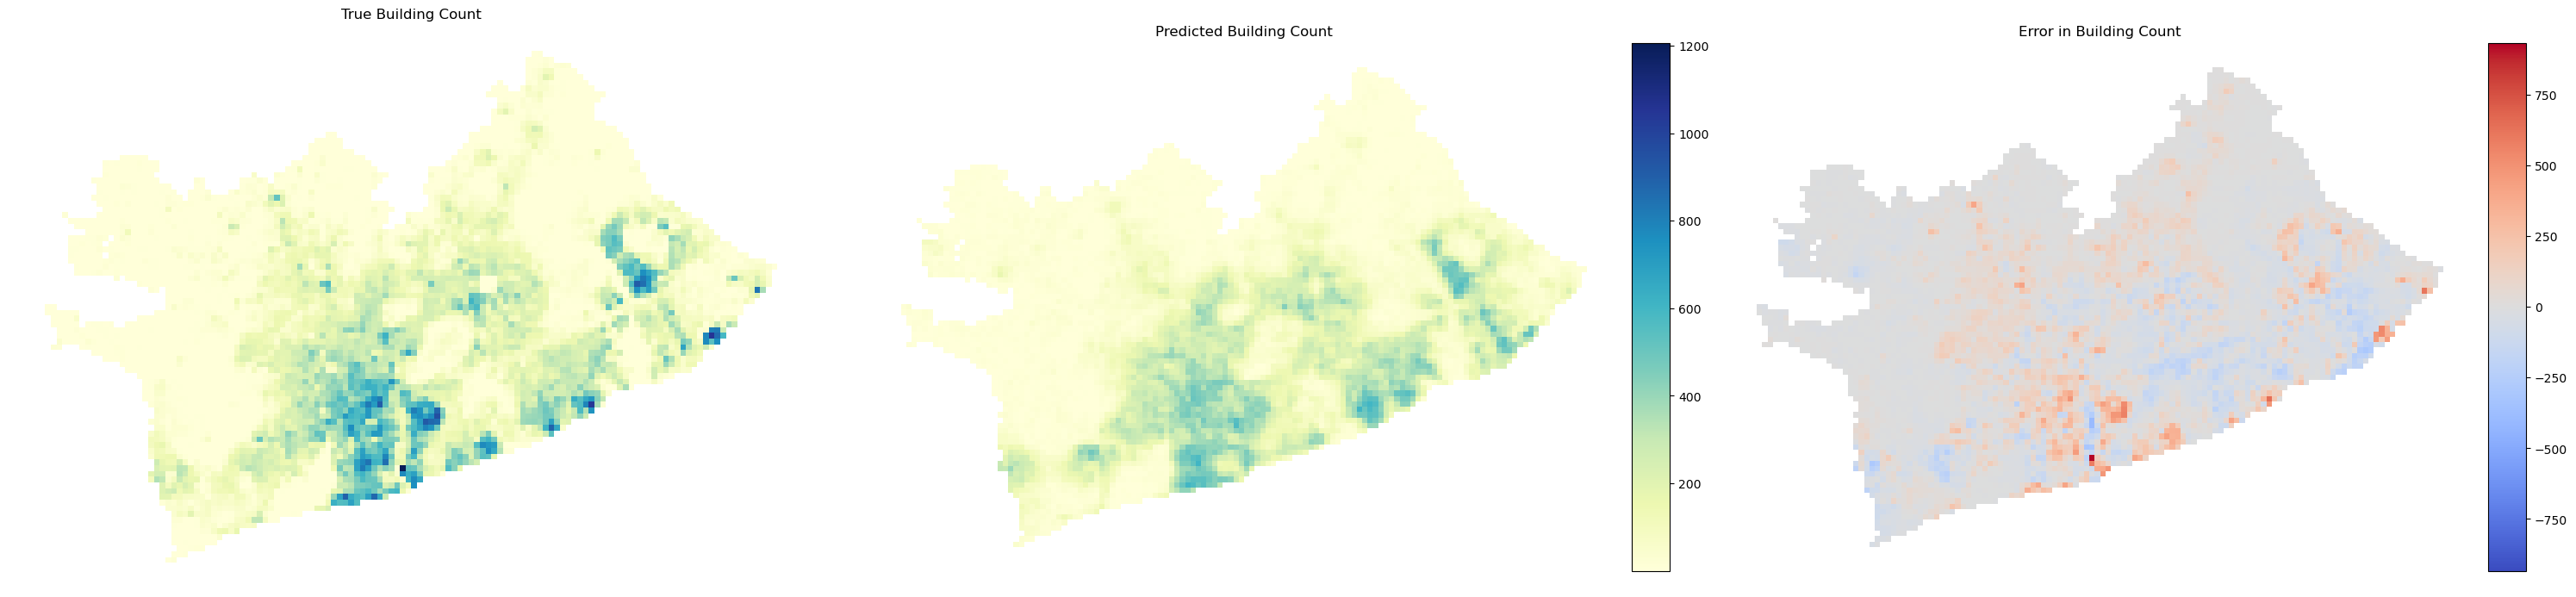

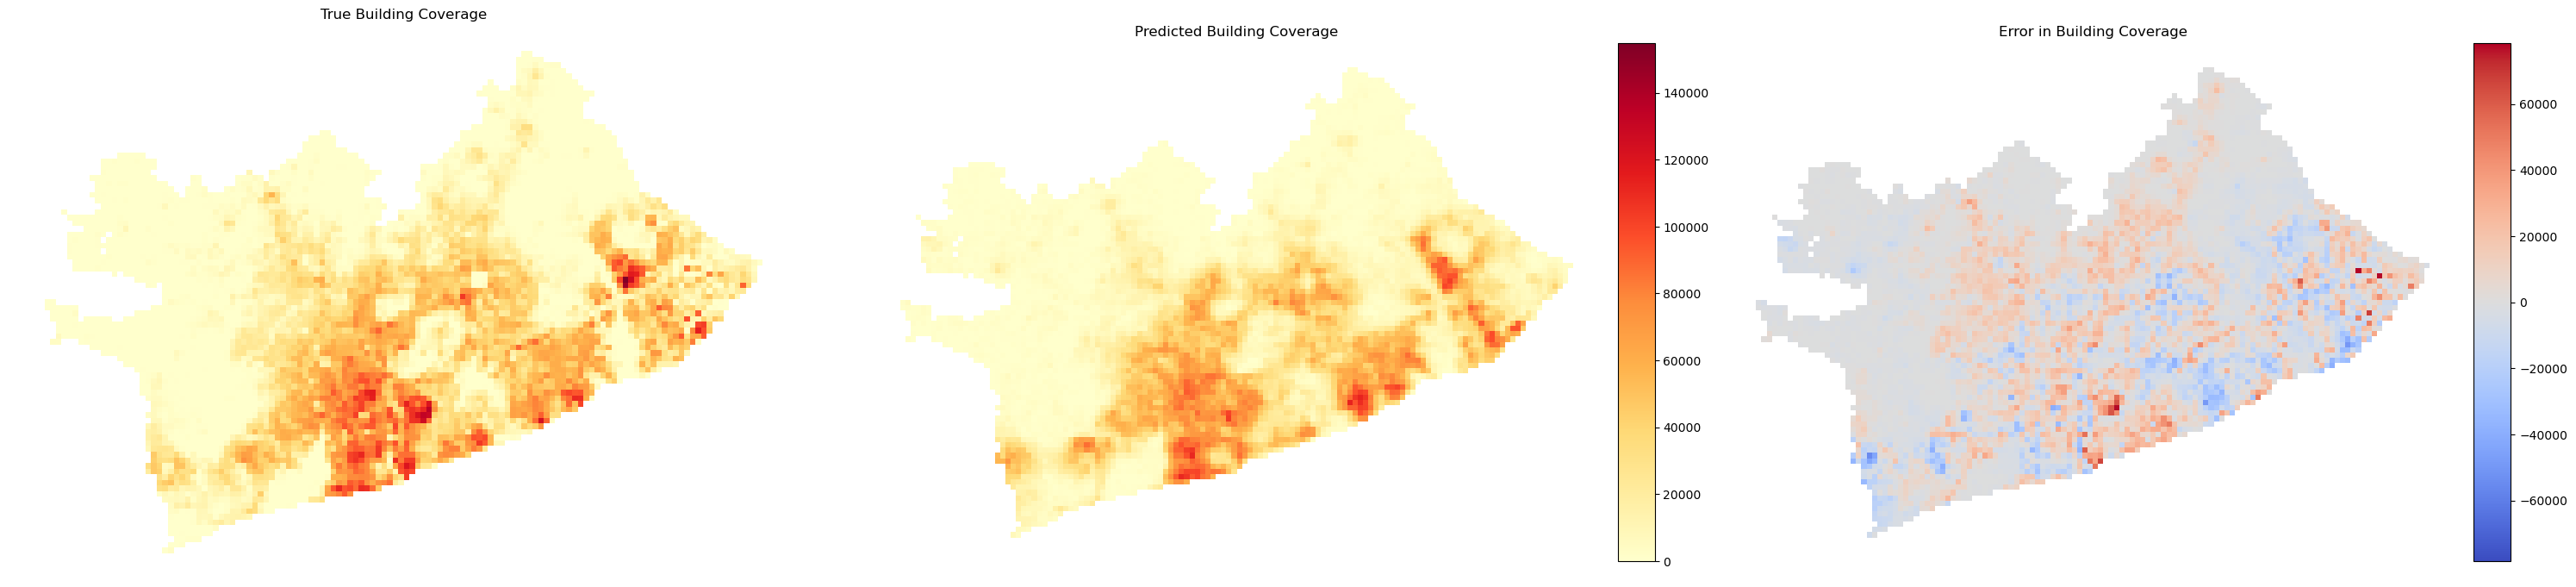

In [47]:
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming 'pixel_df' is your GeoDataFrame with the correct CRS
pixel_df['predicted_count'] = y_pred_count_all
pixel_df['predicted_coverage'] = y_pred_coverage_all

import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

def plot_true_predicted_error(gdf, true_column, pred_column, true_title, pred_title, error_title, cmap_true_pred='viridis', cmap_error='coolwarm'):
    """
    Plot the true, predicted values, and error of a specific column of the GeoDataFrame.
    
    Parameters:
    - gdf: GeoDataFrame to plot.
    - true_column: The name of the column with true values.
    - pred_column: The name of the column with predicted values.
    - true_title: The title of the plot for true values.
    - pred_title: The title of the plot for predicted values.
    - error_title: The title of the plot for the error.
    - cmap_true_pred: The colormap to use for true and predicted values.
    - cmap_error: The colormap to use for the error values.
    """
    fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)

    # Find common range for colorbar for true and predicted values
    vmin_true_pred = min(gdf[true_column].min(), gdf[pred_column].min())
    vmax_true_pred = max(gdf[true_column].max(), gdf[pred_column].max())
    
    # Plot true values
    true_plot = gdf.plot(column=true_column, ax=axes[0], cmap=cmap_true_pred, vmin=vmin_true_pred, vmax=vmax_true_pred)
    axes[0].set_title(true_title)
    axes[0].axis('off')
    
    # Plot predicted values
    pred_plot = gdf.plot(column=pred_column, ax=axes[1], cmap=cmap_true_pred, vmin=vmin_true_pred, vmax=vmax_true_pred)
    axes[1].set_title(pred_title)
    axes[1].axis('off')

    # Calculate error and plot
    gdf['error'] = gdf[true_column] - gdf[pred_column]
    vmax_error = np.max(np.abs(gdf['error']))
    error_plot = gdf.plot(column='error', ax=axes[2], cmap=cmap_error, vmin=-vmax_error, vmax=vmax_error)
    axes[2].set_title(error_title)
    axes[2].axis('off')
    
    # Set the colorbar for true and predicted on the first subplot
    divider_true_pred = make_axes_locatable(axes[1])
    cax_true_pred = divider_true_pred.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(pred_plot.get_children()[0], cax=cax_true_pred, ax=[axes[0], axes[1]])
    
    # Set the colorbar for error on the third subplot
    divider_error = make_axes_locatable(axes[2])
    cax_error = divider_error.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(error_plot.get_children()[0], cax=cax_error, ax=axes[2])
    
    # Tighten up layout
    plt.tight_layout()
    plt.savefig('../debug_plots/true_predicted_error_'+true_column+'_2010.png')
plot_true_predicted_error(
pixel_df,
'building_count',
'predicted_count',
'True Building Count',
'Predicted Building Count',
'Error in Building Count',
cmap_true_pred='YlGnBu',
cmap_error='coolwarm'
)

plot_true_predicted_error(
pixel_df,
'building_coverage',
'predicted_coverage',
'True Building Coverage',
'Predicted Building Coverage',
'Error in Building Coverage',
cmap_true_pred='YlOrRd',
cmap_error='coolwarm'
)

In [24]:
# Assuming pixel_df is your GeoDataFrame and it includes columns for predictions
output_shapefile_path = "../pixel_df/pixel_df_2010.shp"

# Save the GeoDataFrame to a shapefile
pixel_df.to_file(output_shapefile_path)

/tmp/ipykernel_121/90767934.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  pixel_df.to_file(output_shapefile_path)


In [31]:
print(pixel_df_2019.columns)

Index(['NDBI', 'MODIS_band', 'MODIS_ba_1', 'MODIS_ba_2', 'MODIS_ba_3',
       'MODIS_ba_4', 'MODIS_ba_5', 'MODIS_ba_6', 'building_c', 'building_1',
       'sqrt_build', 'sqrt_bui_1', 'predicted_', 'predicte_1', 'error',
       'geometry'],
      dtype='object')


In [33]:
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the 2019 data
pixel_df_2019 = gpd.read_file("../pixel_df/pixel_df_2019.shp")

# Load the 2019 data
pixel_df_2019 = gpd.read_file("../pixel_df/pixel_df_2019.shp")

# Correct the column names in pixel_df_2019 to match pixel_df (2010 data)
# Example correction mapping (adjust according to your exact column name distortions)
column_name_mapping = {
    'MODIS_band': 'MODIS_band_1',
    'MODIS_ba_1': 'MODIS_band_2',
    'MODIS_ba_2': 'MODIS_band_3',
    'MODIS_ba_3': 'MODIS_band_4',
    'MODIS_ba_4': 'MODIS_band_5',
    'MODIS_ba_5': 'MODIS_band_6',
    'MODIS_ba_6': 'MODIS_band_7',
    'building_c': 'building_count',
    'building_1': 'building_coverage',
    'sqrt_build': 'sqrt_building_count',
    'sqrt_bui_1': 'sqrt_building_coverage',
    'predicted_': 'predicted_count',
    'predicte_1': 'predicted_coverage',
    # Add other necessary corrections here
}
pixel_df_2019.rename(columns=column_name_mapping, inplace=True)

Model Evaluation on 2019 Data:
Building Count:
RMSE: 132.15692035402904
R^2: 0.6262657715844053
MAPE: 634.4911198839396

Building Coverage:
RMSE: 15347.160658638497
R^2: 0.7140079106887108
MAPE: 503.4434068325521


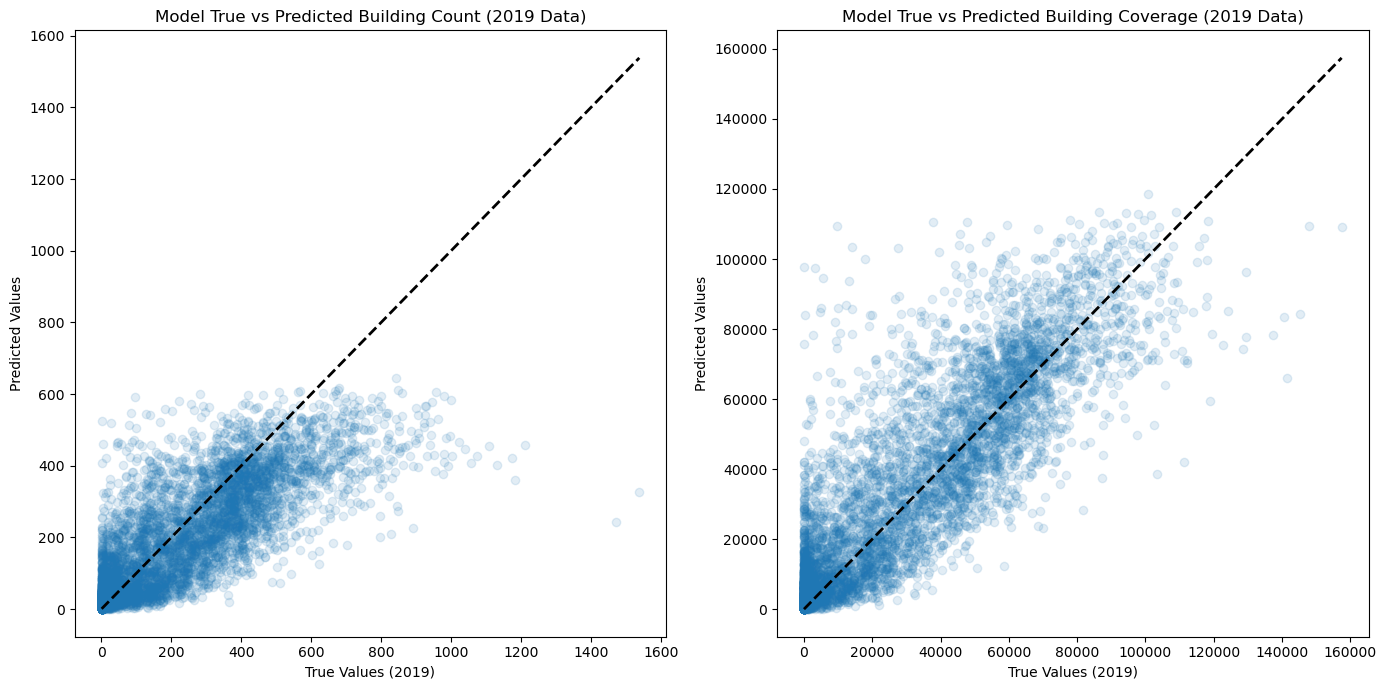

In [34]:
# Assume band_array is defined the same way as when training the 2010 model
band_array = [2, 6, 7]  # Specify the band numbers you want to include, or None for all bands
features = [f'MODIS_band_{i}' for i in range(1, 8)] if band_array is None else [f'MODIS_band_{i}' for i in band_array]

# Extract the features and the target from the 2019 data
X_2019 = pixel_df_2019[features].values
y_count_2019 = pixel_df_2019['sqrt_building_count'].values
y_coverage_2019 = pixel_df_2019['sqrt_building_coverage'].values

# Scale the 2019 features using the same scaler as the 2010 model
# Note: You should save the scaler after fitting on the 2010 data and load it here. For simplicity, we're reusing the scaler variable.
X_scaled_2019 = scaler.transform(X_2019)

# Use the 2010 model to make predictions on the 2019 data
y_pred_count_2019 = final_model_count.predict(X_scaled_2019)
y_pred_coverage_2019 = final_model_coverage.predict(X_scaled_2019)

# Inverse transform the predictions (and true values if necessary)
y_pred_count_2019 = inverse_transform(y_pred_count_2019, transformation='sqrt')
y_pred_coverage_2019 = inverse_transform(y_pred_coverage_2019, transformation='sqrt')
y_count_true_2019 = inverse_transform(y_count_2019, transformation='sqrt')
y_coverage_true_2019 = inverse_transform(y_coverage_2019, transformation='sqrt')

# Evaluation metrics for the model on 2019 data
print("Model Evaluation on 2019 Data:")
print("Building Count:")
print(f"RMSE: {mean_squared_error(y_count_true_2019, y_pred_count_2019, squared=False)}")
print(f"R^2: {r2_score(y_count_true_2019, y_pred_count_2019)}")
print(f"MAPE: {calculate_mape(y_count_true_2019, y_pred_count_2019)}\n")

print("Building Coverage:")
print(f"RMSE: {mean_squared_error(y_coverage_true_2019, y_pred_coverage_2019, squared=False)}")
print(f"R^2: {r2_score(y_coverage_true_2019, y_pred_coverage_2019)}")
print(f"MAPE: {calculate_mape(y_coverage_true_2019, y_pred_coverage_2019)}")

# Plotting the model predictions against true values for the 2019 data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_count_true_2019, y_pred_count_2019, alpha=0.125)
plt.plot([min(y_count_true_2019), max(y_count_true_2019)], [min(y_count_true_2019), max(y_count_true_2019)], 'k--', lw=2)
plt.title('Model True vs Predicted Building Count (2019 Data)')
plt.xlabel('True Values (2019)')
plt.ylabel('Predicted Values')

plt.subplot(1, 2, 2)
plt.scatter(y_coverage_true_2019, y_pred_coverage_2019, alpha=0.125)
plt.plot([min(y_coverage_true_2019), max(y_coverage_true_2019)], [min(y_coverage_true_2019), max(y_coverage_true_2019)], 'k--', lw=2)
plt.title('Model True vs Predicted Building Coverage (2019 Data)')
plt.xlabel('True Values (2019)')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()

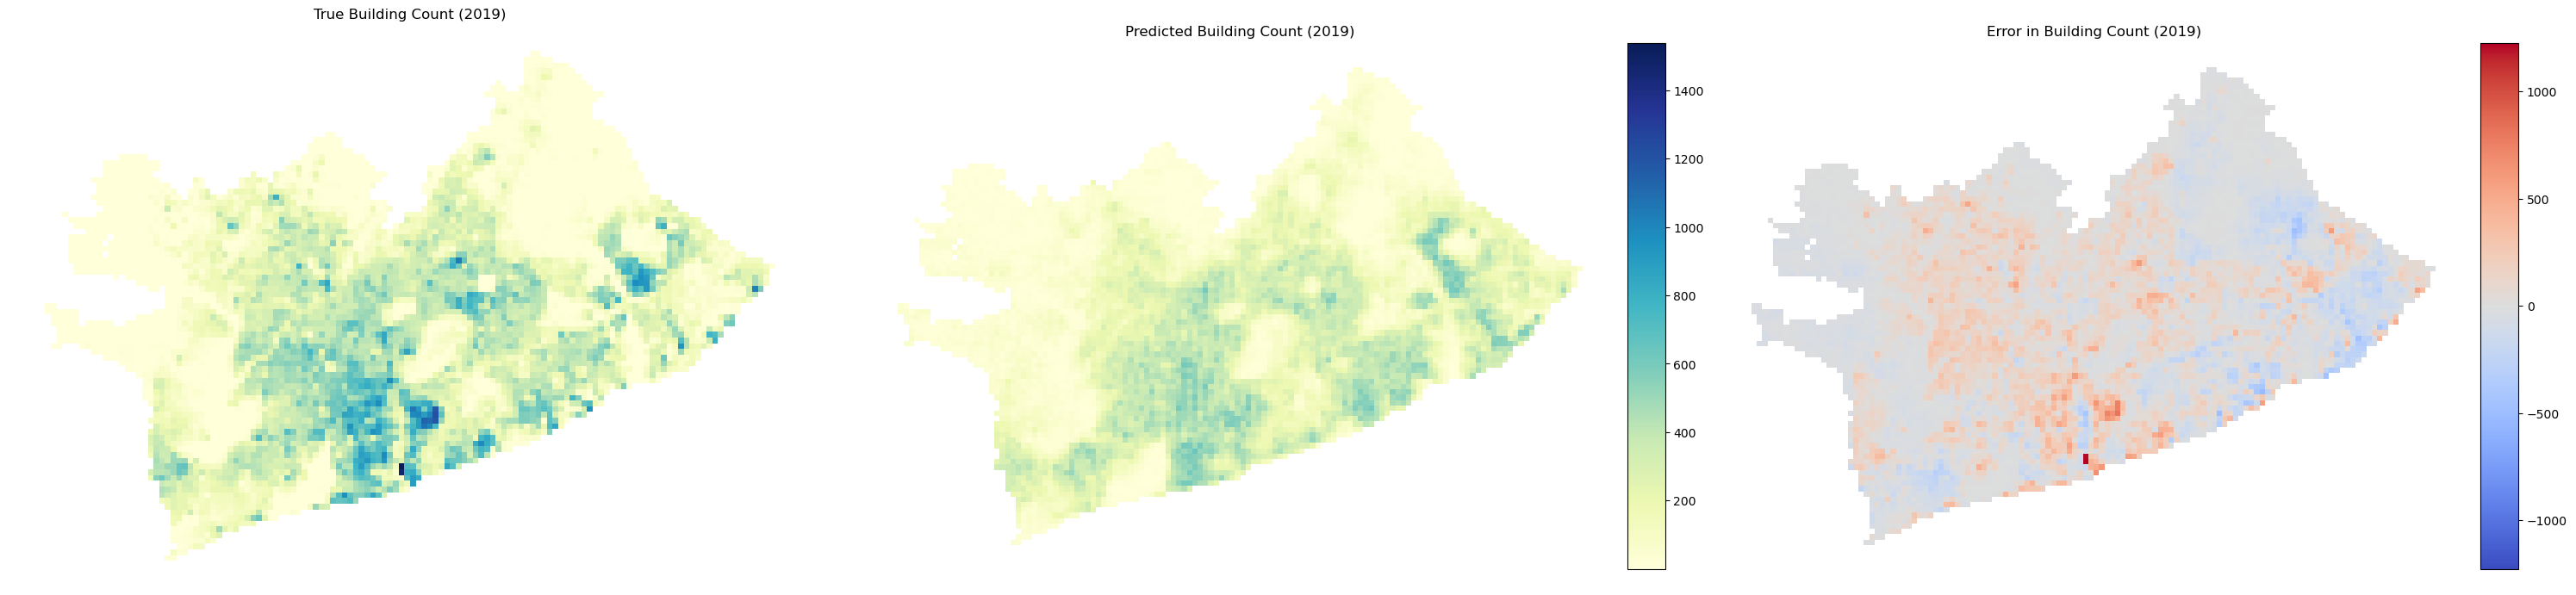

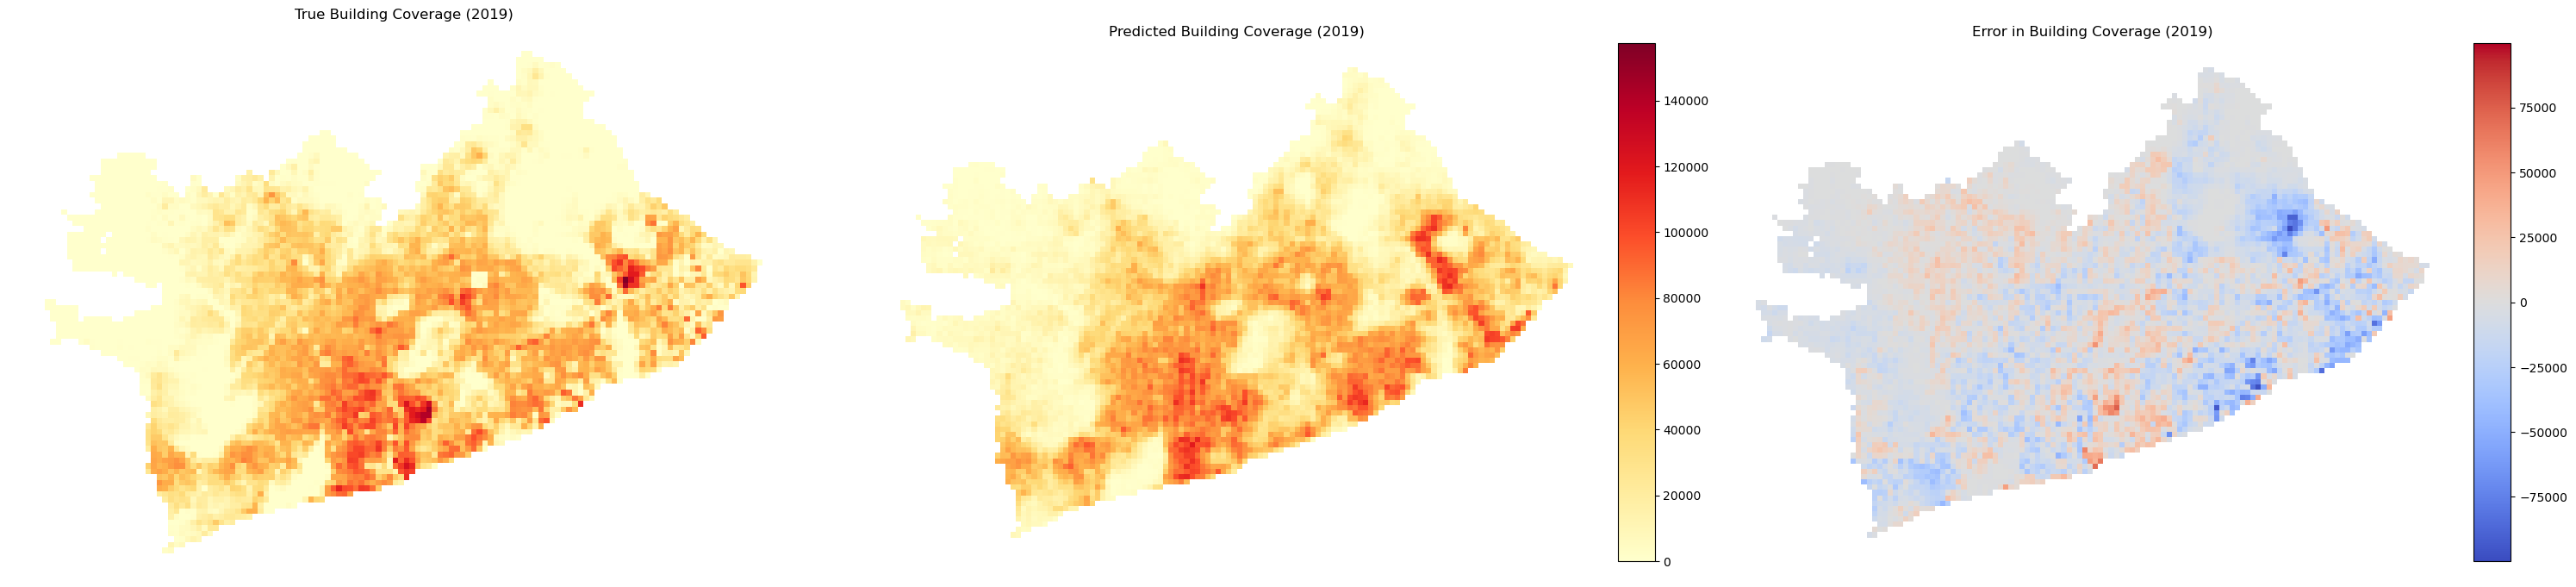

In [50]:
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# Assuming 'pixel_df' is your GeoDataFrame with the correct CRS
pixel_df_2019['predicted_count_2019'] = y_pred_count_2019
pixel_df_2019['predicted_coverage_2019'] = y_pred_coverage_2019

def plot_true_predicted_error_2019(gdf, true_column, pred_column, true_title, pred_title, error_title, cmap_true_pred='viridis', cmap_error='coolwarm'):
    """
    Plot the true, predicted values, and error of a specific column of the GeoDataFrame for the 2019 data.
    
    Parameters:
    - gdf: GeoDataFrame to plot.
    - true_column: The name of the column with true values for 2019.
    - pred_column: The name of the column with predicted values for 2019.
    - true_title: The title of the plot for true values.
    - pred_title: The title of the plot for predicted values.
    - error_title: The title of the plot for the error.
    - cmap_true_pred: The colormap to use for true and predicted values.
    - cmap_error: The colormap to use for the error values.
    """
    fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)

    # Find common range for colorbar for true and predicted values
    vmin_true_pred = min(gdf[true_column].min(), gdf[pred_column].min())
    vmax_true_pred = max(gdf[true_column].max(), gdf[pred_column].max())
    
    # Plot true values
    true_plot = gdf.plot(column=true_column, ax=axes[0], cmap=cmap_true_pred, vmin=vmin_true_pred, vmax=vmax_true_pred)
    axes[0].set_title(true_title)
    axes[0].axis('off')
    
    # Plot predicted values
    pred_plot = gdf.plot(column=pred_column, ax=axes[1], cmap=cmap_true_pred, vmin=vmin_true_pred, vmax=vmax_true_pred)
    axes[1].set_title(pred_title)
    axes[1].axis('off')

    # Calculate error and plot
    gdf['error_2019'] = gdf[true_column] - gdf[pred_column]
    vmax_error = np.max(np.abs(gdf['error_2019']))
    error_plot = gdf.plot(column='error_2019', ax=axes[2], cmap=cmap_error, vmin=-vmax_error, vmax=vmax_error)
    axes[2].set_title(error_title)
    axes[2].axis('off')
    
    # Set the colorbar for true and predicted on the first subplot
    divider_true_pred = make_axes_locatable(axes[1])
    cax_true_pred = divider_true_pred.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(pred_plot.get_children()[0], cax=cax_true_pred, ax=[axes[0], axes[1]])
    
    # Set the colorbar for error on the third subplot
    divider_error = make_axes_locatable(axes[2])
    cax_error = divider_error.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(error_plot.get_children()[0], cax=cax_error, ax=axes[2])
    
    # Tighten up layout
    plt.tight_layout()
    plt.show()

# Assuming pixel_df_2019 includes 'predicted_count_2019' and 'predicted_coverage_2019'
plot_true_predicted_error_2019(
    pixel_df_2019,
    'building_count',
    'predicted_count_2019',
    'True Building Count (2019)',
    'Predicted Building Count (2019)',
    'Error in Building Count (2019)',
    cmap_true_pred='YlGnBu',
    cmap_error='coolwarm'
)

plot_true_predicted_error_2019(
    pixel_df_2019,
    'building_coverage',
    'predicted_coverage_2019',
    'True Building Coverage (2019)',
    'Predicted Building Coverage (2019)',
    'Error in Building Coverage (2019)',
    cmap_true_pred='YlOrRd',
    cmap_error='coolwarm'
)
